# Single Cell apoptosis

#### As decribed in Monier et al. 2015

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize

from tyssue.core.sheet import Sheet
from tyssue.config.json_parser import load_default


from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.dynamics.sheet_vertex_model import SheetModel as basemodel
from tyssue.solvers.sheet_vertex_solver import Solver as solver

#from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.vispy_draw import vp_view
from tyssue.topology.sheet_topology import type1_transition, remove_face

from tyssue.draw.mpl_draw import sheet_view
import tyssue.draw.mpl_draw as draw
from tyssue.stores import load_datasets

### Loading a dataset

Here it is a cylindrical hexagonal mesh.

In [2]:
h5store = 'before_apoptosis.hf5'
#h5store = 'small_hexagonal.hf5'

datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])
sheet = Sheet('emin', datasets)
sheet.set_geom('sheet')
geom.update_all(sheet)

nondim_specs = load_default('dynamics', 'sheet')
dim_model_specs = model.dimentionalize(nondim_specs)

sheet.set_model('sheet', dim_model_specs)

live_edges = sheet.upcast_face(sheet.face_df.is_alive)
dead_src = set(sheet.edge_df[live_edges==0].srce)

sheet.vert_df.is_active = 1
sheet.vert_df.loc[dead_src, 'is_active'] = 0

In [3]:
settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-6,    
            'gtol': 1e-5},
        }
    }

res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])

True


In [12]:
vp_view(sheet, coords=['z', 'x', 'y'])

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)


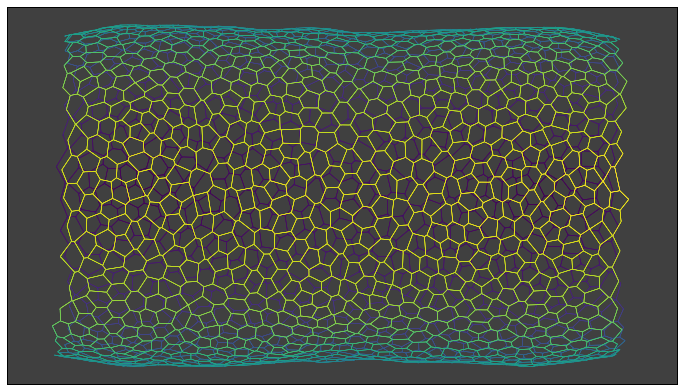

In [5]:
def leg_joint_view(sheet, coords=['z', 'y', 'x']):

    x, y, z = coords
    datasets = {}
    
    datasets['face'] = sheet.face_df.sort_values(z)
    datasets['vert'] = sheet.vert_df.sort_values(z)
    edge_z = 0.5 * (sheet.upcast_srce(sheet.vert_df[z]) +
                    sheet.upcast_trgt(sheet.vert_df[z]))
    datasets['edge'] = sheet.edge_df.copy()
    datasets['edge'][z] = edge_z
    datasets['edge'] = datasets['edge'].sort_values(z)
    
    tmp_sheet = Sheet('tmp', datasets,
                      sheet.specs)
    tmp_sheet.reset_index()
    cmap = plt.cm.get_cmap('viridis')
    
    e_depth = (tmp_sheet.edge_df[z] -
               tmp_sheet.edge_df[z].min()) / tmp_sheet.edge_df[z].ptp()
    depth_cmap = cmap(e_depth)
    draw_specs = {
        'vert': {
            'visible': False
            },
        'edge': {
            'color': depth_cmap,
            #'zorder': depth.values
            }
        }
    
    fig, ax = sheet_view(tmp_sheet, coords[:2], **draw_specs)
    ax.set_xlim(-80, 80)
    ax.set_ylim(-45, 45)
    ax.set_axis_bgcolor('#404040')
    ax.set_xticks([])
    ax.set_yticks([])
    fig.set_size_inches((12, 12))
    return fig, ax

fig, ax = leg_joint_view(sheet)


In [6]:
apoptotic_cell = 1052
print('Apoptotic cell position:\n{}'.format(sheet.face_df.loc[apoptotic_cell, sheet.coords]))
apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]
apoptotic_verts = apoptotic_edges['srce'].values
print("Indices of the apoptotic vertices: {}".format(apoptotic_verts))

Apoptotic cell position:
x     0.940405
y    39.495760
z    -1.669775
Name: 1052, dtype: float64
Indices of the apoptotic vertices: [ 474 2040 2041  476 2205  477]


In [7]:
from tyssue.behaviors.sheet_events import SheetEvents
from tyssue.behaviors.behaviors import apoptosis_time_table
events = SheetEvents(sheet, model, geom).events

print('Defined events (single time step)')
print('\n'.join([k for k in events]))


Defined events (single time step)
ab_pull
type3
divide
grow
contract
type1_at_shorter
shrink


In [8]:
sheet.settings['apoptosis'] = {
    'shrink_steps': 20,
    'rad_tension': 1,
    'contractile_increase': 2,
    'contract_span': 2
    }

In [9]:
times, time_table = apoptosis_time_table(sheet,
                                         apoptotic_cell,
                                         events,
                                         start_t=0)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/core/objects.py:579: PerformanceWarning: indexing past lexsort depth may impact performance.
  opposite = st_indexed.loc[flipped, 'edge'].values


In [11]:
for t in times:
    face_events = time_table.loc[t]
    for face, evts in face_events.iterrows():
        for event_name, event_arg in evts.dropna().items():
            events[event_name](face, event_arg)

    res = solver.find_energy_min(sheet, geom, model, **settings)
    fig, ax = leg_joint_view(sheet)
    plt.savefig('single_apopto_{:03d}.png'.format(t))
    plt.close(fig)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/core/objects.py:579: PerformanceWarning: indexing past lexsort depth may impact performance.
  opposite = st_indexed.loc[flipped, 'edge'].values


In [13]:
sheet.face_df.loc[1052, 'prefered_vol']

0.0

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/core/objects.py:579: PerformanceWarning: indexing past lexsort depth may impact performance.
  opposite = st_indexed.loc[flipped, 'edge'].values


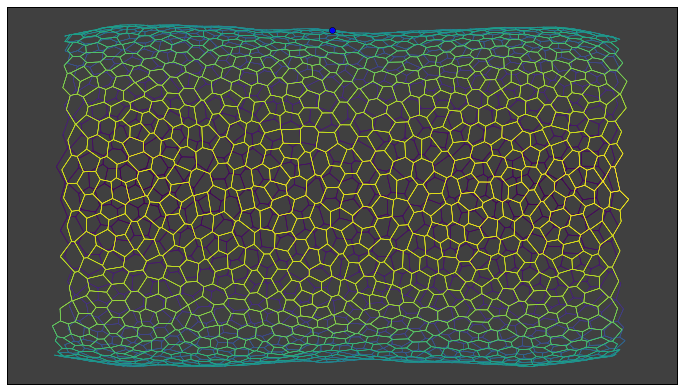

In [15]:
fig, ax = leg_joint_view(sheet)
ax.plot(sheet.face_df.loc[1052, 'z'], sheet.face_df.loc[1052, 'y'], 'o')